In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [23]:
rng = np.random.RandomState(20170720)
data = pd.read_csv('data.csv')

n_bootstrap = 1000000
repetitions = 3

In [24]:
state_black = data['Fraction Black'].values
state_woman = data['Fraction Female'].values

In [25]:
for ii in range(repetitions):
    print('{} out of {}'.format(ii, repetitions))
    senate_woman = rng.rand(n_bootstrap, 50, 2) < state_woman[np.newaxis, :, np.newaxis]
    senate_black = rng.rand(n_bootstrap, 50, 2) < state_black[np.newaxis, :, np.newaxis]
    both_women_per_state = senate_woman[..., 0] * senate_woman[..., 1]
    if ii == 0:
        n_states_2_women = both_women_per_state.sum(axis=1)
        n_black_women = np.sum(senate_woman * senate_black, axis=(1, 2))
        n_black = senate_black.sum(axis=(1, 2))
        n_women = senate_woman.sum(axis=(1, 2))
    else:
        n_states_2_women = np.concatenate([n_states_2_women, both_women_per_state.sum(axis=1)])
        n_black_women = np.concatenate([n_black_women, np.sum(senate_woman * senate_black, axis=(1, 2))])
        n_black = np.concatenate([n_black, senate_black.sum(axis=(1, 2))])
        n_women = np.concatenate([n_women, senate_woman.sum(axis=(1, 2))])

0 out of 3
1 out of 3
2 out of 3


In [26]:
def make_plots(data, reality, description):
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        h, b, p = ax.hist(data, bins=np.arange(0, 101), normed=True)
        ax.plot([reality + .5, reality + .5], [0, 1], c='black')
        ax.set_ylim(h[h>0].min()/10., 1)
        ax.set_xlim(-1, data.max() + 2)
        ax.set_xlabel('Number of {}'.format(description))
        ax.set_ylabel('Probability')
    axes[0].set_ylim(0, .2)
    axes[0].set_yticks([0, .1, .2])
    axes[1].set_yscale('log')
    print('p for {} or fewer {}: {}'.format(reality, description, np.mean(data <= reality)))
    print('mean for {}: {}'.format(description, data.mean()))
    print('mode for {}: {} at {} probability'.format(description, h.argmax(), h.max()))

p for 3 or fewer states with 2 women senators: 0.000321333333333
mean for states with 2 women senators: 12.8559013333
mode for states with 2 women senators: 13 at 0.127901 probability


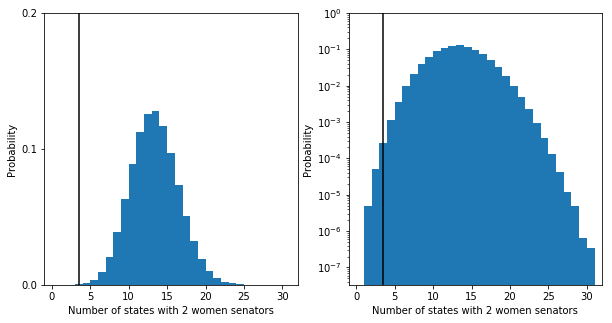

In [27]:
make_plots(n_states_2_women, 3, 'states with 2 women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/2WomenStates.png'), dpi=300)
plt.show()

p for 21 or fewer women senators: 0.0
mean for women senators: 50.6995886667
mode for women senators: 51 at 0.079549 probability


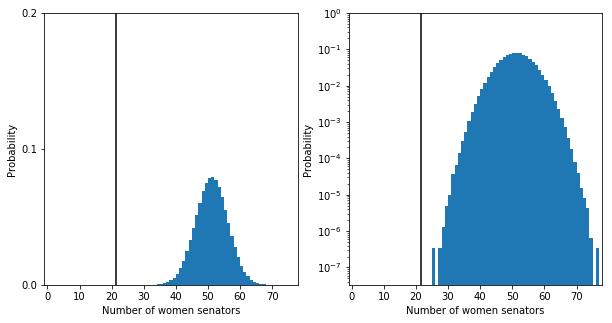

In [28]:
make_plots(n_women, 21, 'women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/21Women.png'), dpi=300)
plt.show()

p for 1 or fewer Black women senators: 0.0262616666667
mean for Black women senators: 5.278061
mode for Black women senators: 5 at 0.182938 probability


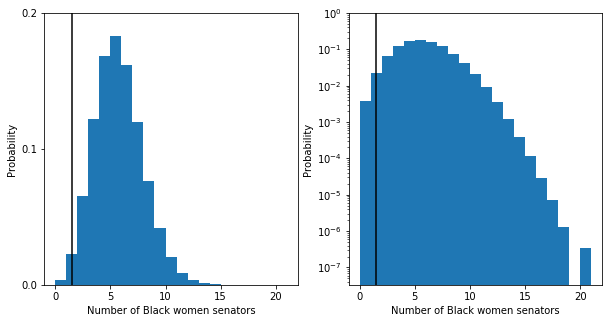

In [29]:
make_plots(n_black_women, 1, 'Black women senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/1BlackWoman.png'), dpi=300)
plt.show()

p for 3 or fewer Black senators: 0.00434333333333
mean for Black senators: 10.3387146667
mode for Black senators: 10 at 0.138122666667 probability


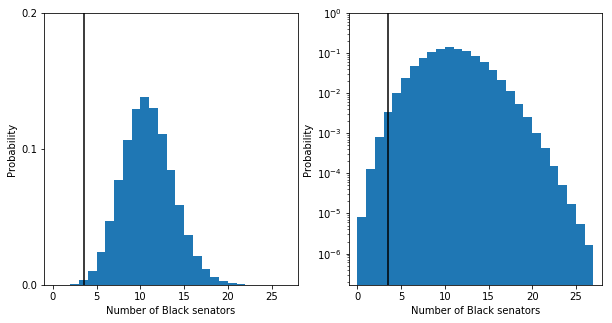

In [30]:
make_plots(n_black, 3, 'Black senators')
plt.savefig(os.path.join(os.environ['HOME'],'Downloads/3Black.png'), dpi=300)
plt.show()

# Coins 

In [40]:
def factorial(n):
    """Compute n!."""
    result = 1
    for ii in range(1, n+1):
        result *= ii
    return result

def odds(n, h):
    """Compute the odds of getting h heads in n coin-flips."""
    return .5**n * (factorial(n))/(factorial(n-h))/(factorial(h))

In [50]:
print(odds(10, 5))
print(odds(10, 7))

0.24609375
0.1171875


In [51]:
print(odds(100, 50))
print(odds(100, 70))

0.07958923738717878
2.3170690580135177e-05


In [52]:
(factorial(100))/(factorial(100-21))/(factorial(21))

2.0418414110621324e+21

# Fast

In [10]:
import theano
import theano.tensor as T
from theano.sandbox import rng_mrg

Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 30.0% of memory, cuDNN 4007)


In [54]:
sw = theano.shared(state_woman.astype('float32'))
sb = theano.shared(state_black.astype('float32'))

t_rng = rng_mrg.MRG_RandomStreams(20170720)
ru_w = t_rng.uniform((n_bootstrap, 50, 2))
ru_b = t_rng.uniform((n_bootstrap, 50, 2))

senate_woman = T.switch(ru_w < sw.dimshuffle('x', 0, 'x'), 1., 0.)
senate_black = T.switch(ru_b < sw.dimshuffle('x', 0, 'x'), 1., 0.)
both_women_per_state = senate_woman[:, :, 0] * senate_woman[:, :, 1]
black_woman = senate_woman * senate_black
n_states_2_women = both_women_per_state.sum(axis=1)
n_black_women = black_woman.sum(axis=(1, 2))
n_black = senate_black.sum(axis=(1, 2))
n_women = senate_woman.sum(axis=(1, 2))
f = theano.function([], [n_states_2_women, n_black_women, n_black, n_women])

In [32]:
for ii in range(repetitions):
    print('{} out of {}'.format(ii, repetitions))
    ns2w, nbw, nb, nw = f()
    if ii == 0:
        n_states_2_women = ns2w
        n_black_women = nbw
        n_black = nb
        n_women = nw
    else:
        n_states_2_women = np.concatenate([n_states_2_women, ns2w])
        n_black_women = np.concatenate([n_black_women, nbw])
        n_black = np.concatenate([n_black, nb])
        n_women = np.concatenate([n_women, nw])

0 out of 3
1 out of 3
2 out of 3


In [38]:
def one():
    senate_woman = rng.rand(n_bootstrap, 50, 2) < state_woman[np.newaxis, :, np.newaxis]
    senate_black = rng.rand(n_bootstrap, 50, 2) < state_black[np.newaxis, :, np.newaxis]
    both_women_per_state = senate_woman[..., 0] * senate_woman[..., 1]
    n_states_2_women = both_women_per_state.sum(axis=1)
    n_black_women = np.sum(senate_woman * senate_black, axis=(1, 2))
    n_black = senate_black.sum(axis=(1, 2))
    n_women = senate_woman.sum(axis=(1, 2))

In [39]:
%timeit f()

1 loop, best of 3: 1.35 s per loop


In [40]:
%timeit one()

1 loop, best of 3: 3.63 s per loop


In [26]:
senate_woman.dtype

'float32'

In [21]:
ru_w.dtype

'float32'

In [55]:
f.maker.fgraph.toposort()

[GpuDimShuffle{x,0,x}(<CudaNdarrayType(float32, vector)>),
 GpuElemwise{Composite{Switch(LT(i0, i1), i2, i3)},no_inplace}(CudaNdarrayConstant{[[[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]
 
  [[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]
 
  [[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]
 
  ..., 
  [[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]
 
  [[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]
 
  [[ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]
   ..., 
   [ 1.  1.]
   [ 1.  1.]
   [ 1.  1.]]]}, GpuDimShuffle{x,0,x}.0, CudaNdarrayConstant{[[[ 1.]]]}, CudaNdarrayConstant{[[[ 0.]]]}),
 GpuCAReduce{add}{0,1,1}(GpuElemwise{Composite{Switch(LT(i0, i1), i2, i3)},no_inplace}.0),
 GpuSubtensor{::, ::, int64}(GpuElemwise{Composite{Switch(LT(i0, i1), i2, i3)},no_inplace}.0, Constant{1}),
 GpuSubtensor{::, ::, 

In [42]:
senate_woman.dtype

'float32'

In [ ]:
senate_woman.